In [1]:
import cartopy.crs as ccrs
import intake
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import pyremo as pr
import cordex as cx
import cmaps
import glob
import xesmf as xe
from REMO2020_mod import modelclass, season_mean, open_mfdataset, cut_rotated, domainclass, plotclass, remo_plotter

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/ikercordex/share/proj failed
/tmp/ipykernel_1821837/1255982410.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,Workers: 16
Total threads: 256,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37527,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:34093,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/40917/status,Memory: 14.71 GiB
Nanny: tcp://127.0.0.1:36781,


In [3]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("036032","REMO2020$_{49}$",True))
modelruns.append(modelclass("036039","REMO2020$_{49}$ iMOVE",True))

In [4]:
# give path, prefix and suffix (the main name for the plots)
figpath = './figures/'
prefix = 'cds_lai_seas_'
suffix = 'REMO2020_2749_main'

In [5]:
# REMO and LAI datapath
rdata = './data_in/model_data/'
laidata = './data_in/LAI/'

In [6]:
# define star year and end year
ystart=2001
yend=2010

In [7]:
# Define the order of seasons to be used (also when plotting)
seasons = ["DJF","MAM","JJA","SON"]

In [8]:
# Load the lake mask
lake_mask = xr.open_dataset(rdata+"FLake_input/flake_v3_glcc_defD10.0m_frac_EUR-11.nc")["FLFRA"]

In [9]:
# lake fraction cut-off limit
clake = 0.5

In [10]:
# Open remapped LAI files
yearlist = np.arange(ystart,yend+1)
filenames = []
for year in yearlist:
    pattern = laidata+"c3s_LAI_"+str(year)+"*_EUR-11_VGT_V1.0.1.nc"
    filenames += glob.glob(pattern)
    filenames.sort()

In [11]:
# Open data
dsLAI = open_mfdataset(filenames, parallel=False, chunks='auto')

In [12]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    obj.filenames = []
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [13]:
# Set halo zone length (will be cutted out)
halo = 8

In [14]:
# calculate the LAI difference
ii = 0
for obj in modelruns:
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    lai = pr.parse_dates(ds.VLT)
    # Merge data (get identical coordinates)
    lai_all = xr.merge([lai, dsLAI.LAI,lake_mask.squeeze().rename("lake_mask")], compat="override", join="override")
    # Calculate absolute values
    if(ii == 0):
        abs_vals = lai_all[["LAI"]].where(lai_all.lake_mask < clake, drop=False).compute()
        abs_vals_mean = season_mean(abs_vals)
        abs_vals_mean = abs_vals_mean.LAI.isel(rlat=slice(halo+1,abs_vals_mean.sizes["rlat"]-halo+1), rlon=slice(halo+1,abs_vals_mean.sizes["rlon"]-halo+1)).compute()
    # apply masking and subtract the values, finally making seasonal means
    obj.vardiff = season_mean(lai_all.VLT.where(lai_all.lake_mask < clake,drop=False) - abs_vals).squeeze()
    # cut halo
    obj.vardiff = obj.vardiff.LAI.isel(rlat=slice(halo+1,obj.vardiff.sizes["rlat"]-halo+1), rlon=slice(halo+1,obj.vardiff.sizes["rlon"]-halo+1)).compute()
    # not supported, set to zero
    obj.mask = np.zeros(len(seasons))
    # Increase counter
    ii = ii + 1
    #t_stat
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)
        rotated_pole = ccrs.RotatedPole(pole[0], pole[1])
        extent = ([ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()], rotated_pole)
    # clean memory
    del ds, lai, lai_all
# clean memory
del abs_vals, dsLAI

/work/ch0636/g300096/Python/envs/ikercordex/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/ikercordex/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/ikercordex/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/ikercordex/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/work/ch0636/g300096/Python/envs/ikercordex/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cac

In [15]:
# define the domains to be plotted
domaininfo =[] # init
domaininfo.append(domainclass("EU",[-22.5,47.5,30,72.5], hspace=0.35))

In [16]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='LAI [m$^2$/m$^2$]', lspace=np.linspace(0,1,32), vmin=0, vmax=4,linvert=False, cmapp=cmaps.BlAqGrYeOrReVi200)
modplotc = plotclass(label='$\Delta$LAI [m$^2$/m$^2$]', lspace=np.linspace(0,1,16), vmin=-2, vmax=2, linvert=False, cmapp=cmaps.BlueWhiteOrangeRed)

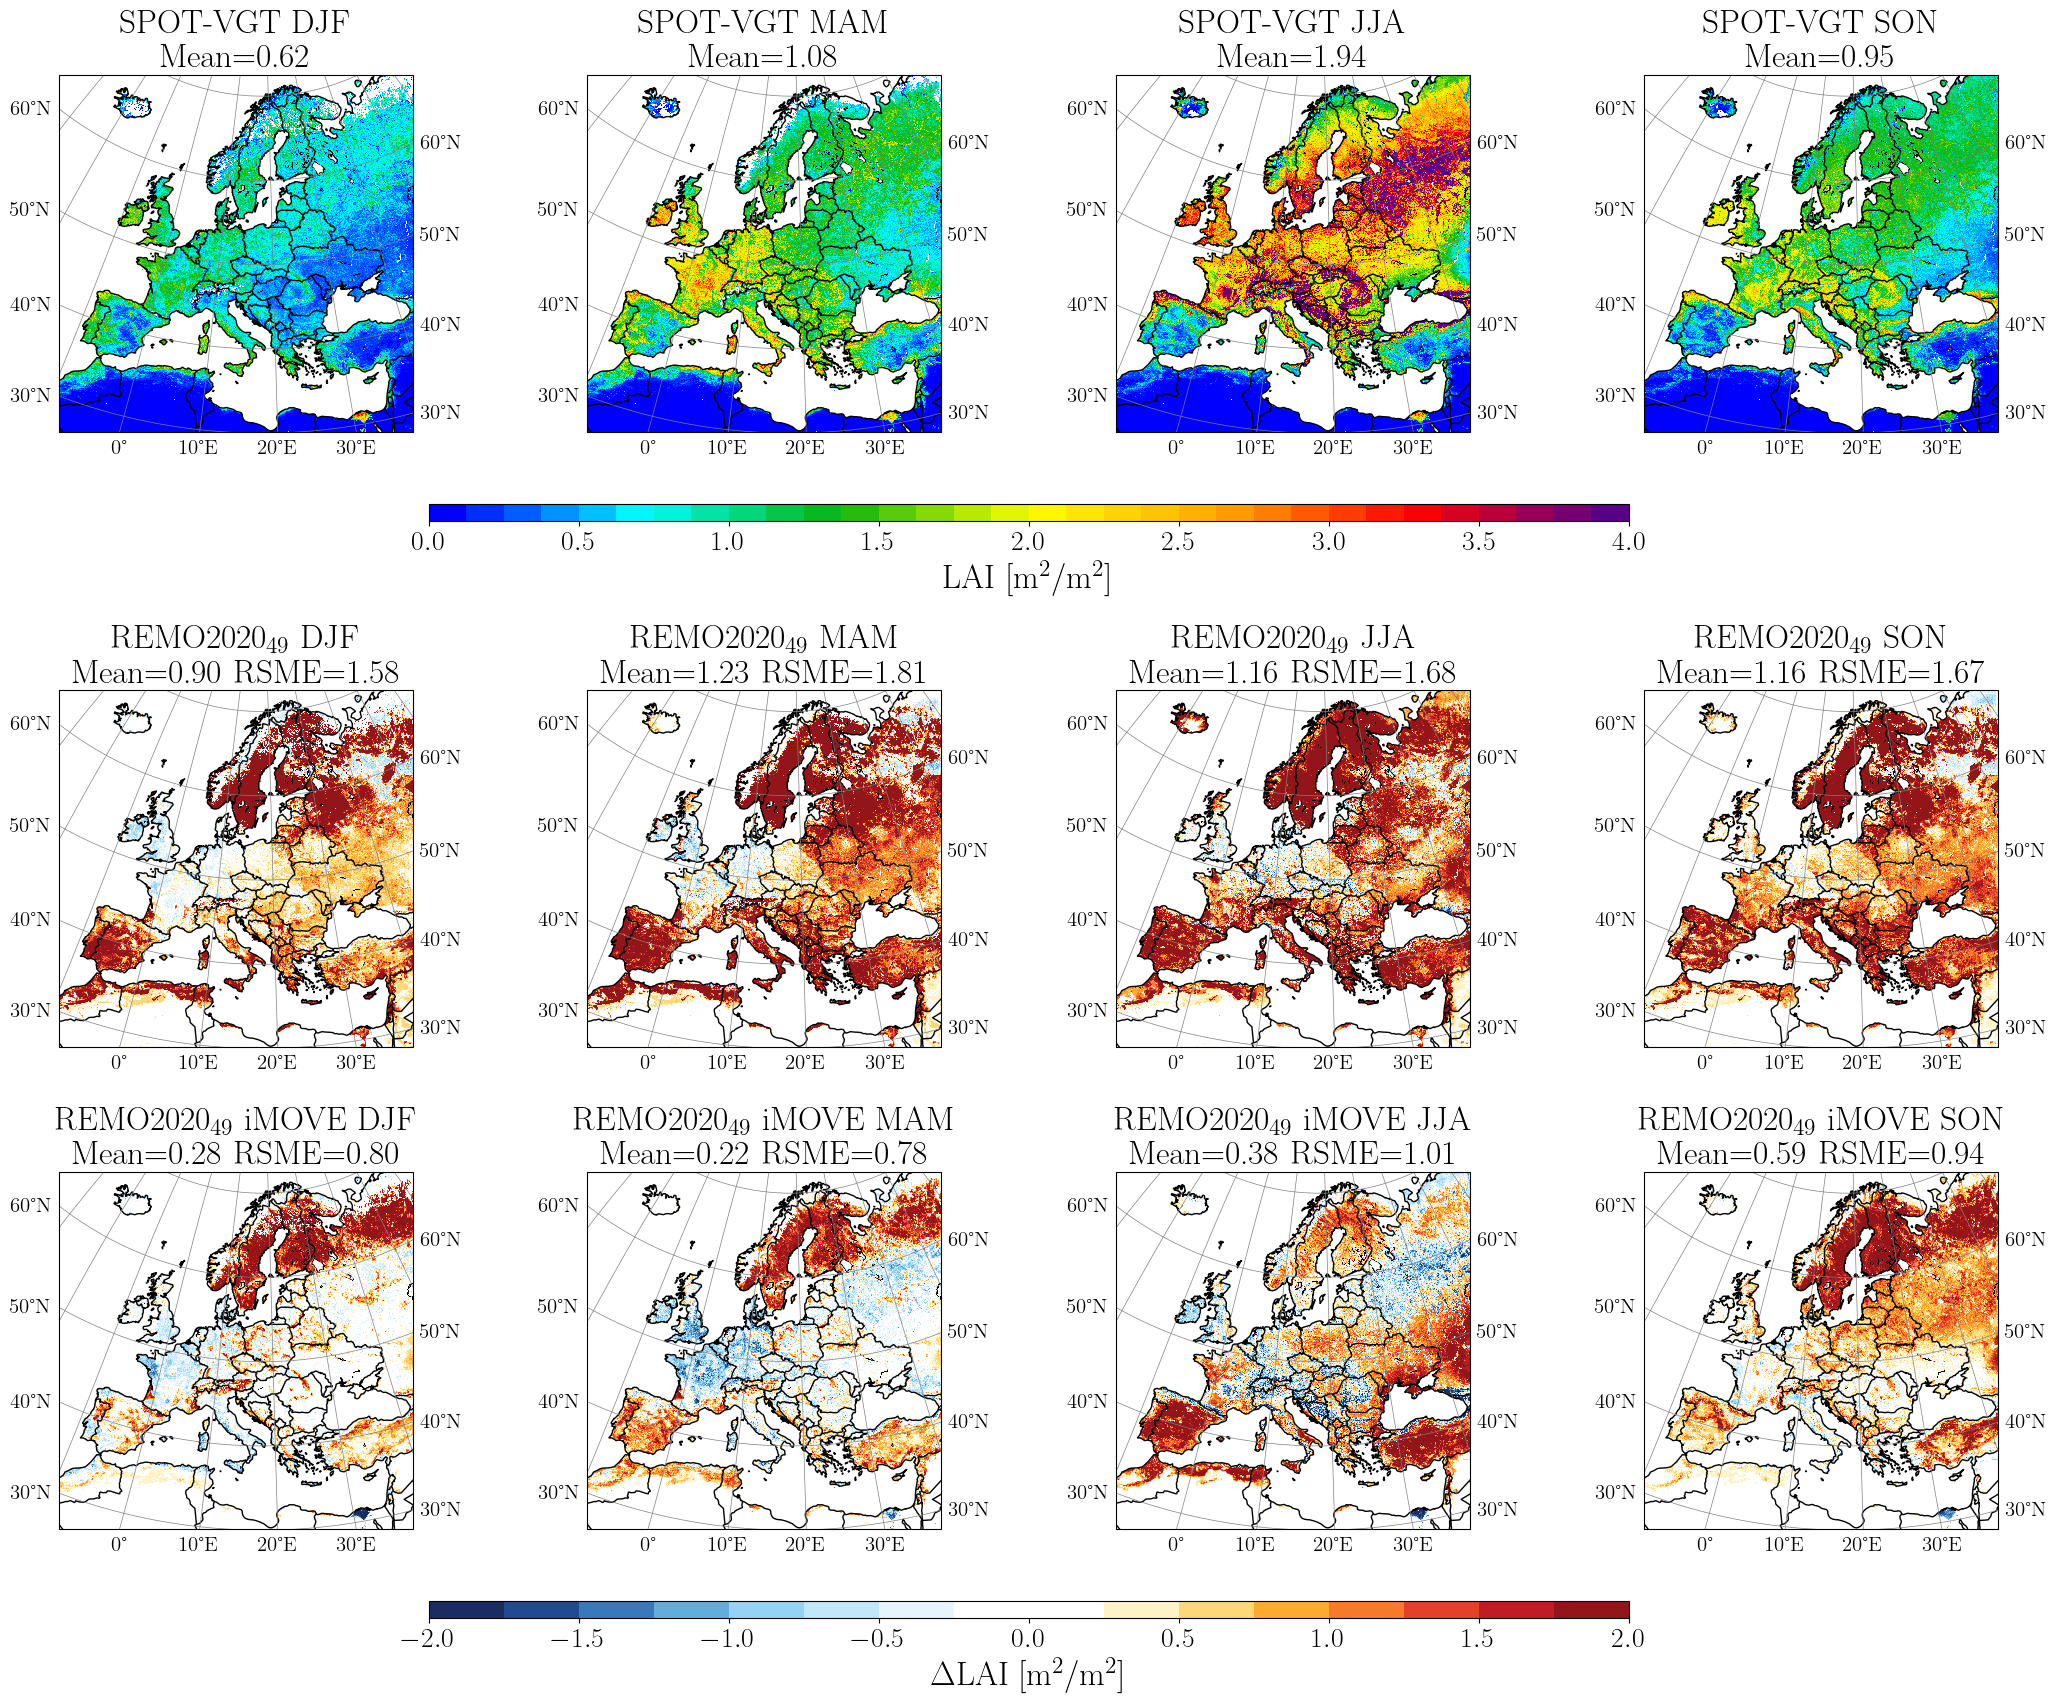

In [18]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter
    remo_plotter(absplotc,modplotc,domaininfo[dom],modelruns,"SPOT-VGT",abs_vals_mean,seasons,pole,False,figpath,figname)